<h2>INVERSE KINEMATICS SOLVER FOR A 6DOF PARALLEL MANIPULATOR WITH 6RSS LEG CONFIGURATION<h2>
 

<h4>Import Packages :<h4>


In [1]:
%matplotlib  notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import numpy as np



<h4> Robot Parameters <h4>

In [2]:
#End Effector Anchor Coordinates in the End Effector Frame of Reference
EndEffectorCoordinates = np.array([[73.7,20,0], 
                                   [53.7,54.1,0],
                                   [-53.7,54.1,0],
                                   [-73.7,20,0],
                                   [-20,-73.55,0],
                                   [ 20,-73.55,0]])
#Base Anchor Coordinates in the Base frame of Reference 
BaseCoordinates =  np.array([[ 81.63, 0.36, 0],
                             [ 41.13 , 70.51, 0],
                             [ -41.13, 70.51 ,0],
                             [-81.63, 0.36, 0],
                             [-41.13 ,-70.51 ,0],
                             [41.13, -70.5, 0]])

#Constants
PI = 3.1416
#Motor Plane angles in Radians in the Base frame of Reference
MotorPlaneAngles = np.array([-PI/3 , 2*PI/3 , -2*PI/3, PI/3, -PI, 0]); 

#RSS Link Parameters
MOTOR_COUPLER_LENGTH = 33.81
SS_LINK_LENGTH=146

# Default Offset of the End effector in the Z direction 
HOME_POSITION_Z_OFFSET =130.64



In [3]:
def UpdateTranslationVector(PoseSetpoint, printoutput):
    delx = PoseSetpoint['delx']
    dely = PoseSetpoint['dely']
    delz = PoseSetpoint['delz']
    TranslationVector = np.array([[delx], [dely], [delz + HOME_POSITION_Z_OFFSET]]);
    
    if printoutput == "TRUE":
        print("TranslationVector" + str(TranslationVector)+ "\n")
        print("Shape of Translation Vector:" + str(TranslationVector.shape) + "\n")
    return TranslationVector

In [4]:
def UpdateRotationMatrix(PoseSetpoint, printoutput):
    Yaw = PoseSetpoint['Yaw']
    Pitch = PoseSetpoint['Pitch']
    Roll = PoseSetpoint['Roll']
    
    Y = 0.0174*Yaw
    P = 0.0174*Pitch
    R = 0.0174*Roll
    RotationMatrix = np.zeros((3,3))
    
    RotationMatrix[0][0] = np.cos(Y)*np.cos(P)
    RotationMatrix[0][1] = -(np.sin(Y)*np.cos(R))+(np.cos(Y)*np.sin(P)*np.sin(R))
    RotationMatrix[0][2] = (np.sin(Y)*np.sin(R)) + (np.cos(Y)*np.sin(P)*np.cos(R))
    RotationMatrix[1][0] = np.sin(Y)*np.cos(P)
    RotationMatrix[1][1] = (np.cos(Y)*np.cos(R))+(np.sin(Y)*np.sin(P)*np.sin(R))
    RotationMatrix[1][2] = (-np.cos(Y)*np.sin(R))+(np.sin(Y)*np.sin(P)*np.cos(R))
    RotationMatrix[2][0] = -np.sin(P)
    RotationMatrix[2][1] = np.cos(P)*np.sin(R)
    RotationMatrix[2][2] = np.cos(P)*np.cos(R)
    
    if printoutput == "TRUE":
        print("RotationMatrix:" + str(RotationMatrix) + "\n")
        print("Shape of Rotation Matrix:" + str(RotationMatrix.shape)+ "\n")
    return RotationMatrix;
    

In [5]:
def EndEffectorCoordinateTransform(RotationMatrix, TranslationVector, printoutput):
    ETransform = TranslationVector + np.dot(RotationMatrix,EndEffectorCoordinates.T)
    
    if printoutput == "TRUE":
        print("Etransform :" + str(ETransform)+ "\n")
        print("Shape of ETransform:" + str(ETransform.shape)+ "\n")
        
    return ETransform

In [6]:
def UpdateEffectiveLinkLengths (ETransform,BaseCoordinates, printoutput):
    
    LinkVectors = np.subtract(ETransform, BaseCoordinates.T)
   
    LinkVectorsSquared = np.square(LinkVectors);
    LinkVectorSquaredSum = np.sum(LinkVectorsSquared, axis = 0, keepdims = True)
    EffectiveLinkLengths = np.sqrt(LinkVectorSquaredSum);
    if printoutput == "TRUE":
        print("EffectiveLinklengths:"+ str(EffectiveLinkLengths)+"\n")
        print("Shape of EffectiveLinkLenghts" + str(EffectiveLinkLengths.shape)+"\n")
        print("LinkVectors:" + str(LinkVectors) + "\n")
        print("Shape of LinkVectors:" + str(LinkVectors.shape)+"\n")
    return LinkVectors , EffectiveLinkLengths

In [7]:
def UpdateMotorAngles(ETransform,EffectiveLinkLengths,BaseCoordinates,printoutput):
    
    diffx =  np.subtract(ETransform[0,:], BaseCoordinates[:,0].T)
    diffy = np.subtract(ETransform[1,:],BaseCoordinates[:,1].T)
    diffz =  np.subtract(ETransform[2,:], BaseCoordinates[:,2].T)
    
    tempM = np.multiply((2*MOTOR_COUPLER_LENGTH),diffz).reshape(1,6)
    tempL = np.square(EffectiveLinkLengths)-(np.square(SS_LINK_LENGTH)-np.square(MOTOR_COUPLER_LENGTH)) 
    temp = np.add(np.multiply(np.cos(MotorPlaneAngles),diffx), np.multiply(np.sin(MotorPlaneAngles), diffy))
    tempN = np.multiply((2*MOTOR_COUPLER_LENGTH),temp).reshape(1,6)
    
    tempsqrt = np.sqrt(np.add(np.square(tempM),np.square(tempN)))
    tempdiv1 = np.divide(tempL,tempsqrt)
    tempdiv2 = np.divide(tempN,tempM)
    
    MotorAnglesRadians = np.arcsin(tempdiv1) - np.arctan(tempdiv2)
    MotorAngles = np.multiply(MotorAnglesRadians, 1/0.0174);
    
    #Modified for the current stewart Platform
    MotorAnglesModified = np.zeros((1,6))
    for motor_index in range(1,7) :
        if motor_index%2 == 0:
            MotorAnglesModified[0][motor_index-1] = MotorAngles[0][motor_index-1]
        else :
            MotorAnglesModified[0][motor_index-1] = -MotorAngles[0][motor_index-1]
    
    if printoutput == "TRUE":
        print("MotorAngles:" + str(MotorAngles) +"\n")
        print("Shape of MotorAngles :" + str(MotorAngles.shape) + "\n" )
    return MotorAngles

In [8]:
def UpdateLinks(MotorAngles,MotorCouplerLength,MotorPlaneAngles,BaseCoordinates, printoutput):
    MotorAnglesRadian = np.multiply(0.0174,MotorAngles)
    temp1 = np.multiply(np.cos(MotorAnglesRadian), np.cos(MotorPlaneAngles))
    LCX = np.add(np.multiply(MotorCouplerLength,temp1), BaseCoordinates[:,0].T) 
    
    temp2 = np.multiply(np.cos(MotorAnglesRadian), np.sin(MotorPlaneAngles))
    LCY = np.add(np.multiply(MotorCouplerLength,temp2), BaseCoordinates[:,1].T) 
    
    LCZ = np.add(np.multiply(MotorCouplerLength,np.sin(MotorAnglesRadian)), BaseCoordinates[:,2].T) 
    LinkCoordinates = np.zeros((3,6))
    LinkCoordinates[0,:] = LCX
    LinkCoordinates[1,:] = LCY
    LinkCoordinates[2,:] = LCZ
    
    if printoutput == "TRUE":

        print("LinkCoordinates:" + str(LinkCoordinates));
        print("ShapeofLinkCoordinates:" + str(LinkCoordinates.shape))
    return LinkCoordinates

In [9]:
def PlotRobot(ETransform,BaseCoordinates,LinkCoordinates):

    fig = plt.figure(figsize =(7,7))
    ax = fig.add_subplot(111, projection='3d')
    
    #Plot End Effector Points
    ax.scatter(ETransform[0,:], ETransform[1,:], ETransform[2,:], marker = "o", c = "red")
    ax.plot(ETransform[0,:], ETransform[1,:], ETransform[2,:], color = "red")
    EndX , EndY, EndZ = [ETransform[0,0],ETransform[0,5]],[ETransform[1,0],ETransform[1,5]],[ETransform[2,0],ETransform[2,5]]
    ax.plot(EndX , EndY, EndZ, color = "red")
    
    #Plot Base Frame Points
    ax.scatter (BaseCoordinates[:,0],BaseCoordinates[:,1],BaseCoordinates[:,2],marker = "o", c = "blue")
    ax.plot(BaseCoordinates[:,0],BaseCoordinates[:,1],BaseCoordinates[:,2],color = "blue")
    EndX , EndY, EndZ = [BaseCoordinates[0,0],BaseCoordinates[5,0]],[BaseCoordinates[0,1],BaseCoordinates[5,1]],[BaseCoordinates[0,2],BaseCoordinates[5,2]]
    ax.plot(EndX , EndY, EndZ, color = "blue")
    
    for motor_index in range(0,6):
        a_x = BaseCoordinates[motor_index,0]
        a_y = BaseCoordinates[motor_index,1]
        a_z = BaseCoordinates[motor_index,2]
        text =str(motor_index +1)
        ax.text(a_x,a_y,a_z, text)
    
    #Plot Link Coordinates
    ax.scatter(LinkCoordinates[0,:], LinkCoordinates[1,:], LinkCoordinates[2,:], marker = "o", c = "green")
    for motor_index in range(0,6):
        EndX , EndY, EndZ =[LinkCoordinates[0,motor_index],BaseCoordinates[motor_index,0]],[LinkCoordinates[1,motor_index], BaseCoordinates[motor_index,1]],[LinkCoordinates[2,motor_index], BaseCoordinates[motor_index,2]]
        ax.plot(EndX , EndY, EndZ, color = "black")
        EndX , EndY, EndZ =[LinkCoordinates[0,motor_index],ETransform[0,motor_index]],[LinkCoordinates[1,motor_index], ETransform[1,motor_index]],[LinkCoordinates[2,motor_index], ETransform[2,motor_index]]
        ax.plot(EndX , EndY, EndZ, color = "black")
        a_x = LinkCoordinates[0,motor_index]
        a_y = LinkCoordinates[1,motor_index]
        a_z = LinkCoordinates[2,motor_index]
        text =str(MotorAngles[0][motor_index])
        #ax.text(a_x,a_y,a_z, text)
    #Include Sliders 
    #axyaw = plt.axes([10,20,30,40])
    #YawSlider = Slider(axyaw ,'Yaw(deg)', valmin = 0 , valmax = 40, valinit = 0)
    
    
    #Set Axis Labels
    ax.set_xlabel("X")
    ax.set_ylabel ("Y")
    ax.set_zlabel("Z")
    ax.set_title("Robot Kinematic Diagram")
    plt.show()
 

MotorAngles:[[ -8.18305526  -8.54154214 -26.42938928 -26.48049352  -8.06491424
   -8.0645148 ]]

Shape of MotorAngles :(1, 6)



<IPython.core.display.Javascript object>


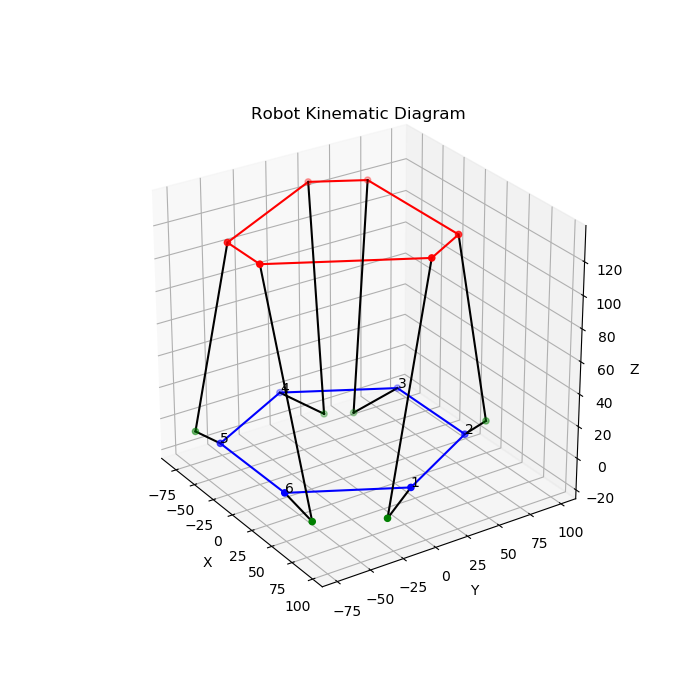

In [10]:

#Define the Pose Setpoint Dictionary. All linear values must be in mm and angles in degrees
PoseSetpoint = {'delx': 0, 'dely' : 0, 'delz' :0, 'Yaw':0, 'Pitch': 0, 'Roll':0}

TranslationVector = UpdateTranslationVector(PoseSetpoint, printoutput = "FALSE")
RotationMatrix = UpdateRotationMatrix(PoseSetpoint,printoutput = "FALSE" )
ETransform = EndEffectorCoordinateTransform(RotationMatrix, TranslationVector, printoutput = "FALSE")
LinkVectors, EffectiveLinkLengths = UpdateEffectiveLinkLengths (ETransform,BaseCoordinates, printoutput = "FALSE")
MotorAngles = UpdateMotorAngles(ETransform,EffectiveLinkLengths,BaseCoordinates,printoutput = "TRUE")
LinkCoordinates = UpdateLinks(MotorAngles,MOTOR_COUPLER_LENGTH,MotorPlaneAngles,BaseCoordinates,printoutput = "FALSE")
PlotRobot(ETransform,BaseCoordinates,LinkCoordinates)